# Data pre-processing

In [1]:
from PIL import Image
import cv2
import os
import pickle 
import random

count_face = 0
count_non_face = 0
for typ in ['trainset','testset']:
    
    input_data = []
    for f in ['faces','non-faces']:
        label = 1 if f =='faces' else 0
        typ_dir="../VJ_dataset/"+typ+"/"+f+"/"
        images=os.listdir(typ_dir) # list of file names
        print(typ, f, len(images))
        for x in images:
            im = cv2.imread(typ_dir+"/"+x,0)
            input_data.append((im,label)) # (image matrix, label (1 or 0))
    random.shuffle(input_data)
    file=open(typ[:-3]+'ing_data.pkl','wb')
    pickle.dump(input_data[:400],file)
    print("Size of {}ing input data : {}".format(typ[:-3],len(input_data)))
    print("DONE")
    file.close()

trainset faces 499
trainset non-faces 2000
Size of training input data : 2499
DONE
testset faces 472
testset non-faces 19572
Size of testing input data : 20044
DONE


# Modeling

In [2]:
import numpy as np
import math
import pickle
from tqdm import tqdm

In [3]:
def integralImage(i_origianl):
    # integral image at location x, y contains the sum of the pixels in 0 ~ x-1 and 0 ~ y-1
    ii_integral_image = np.zeros(i_origianl.shape)
    s = np.zeros(i_origianl.shape)
    for j in range(len(i_origianl)): # y
        for i in range(len(i_origianl[j])): # x
            s[j][i] = s[j-1][i] + i_origianl[j][i] if j-1 >= 0 else i_origianl[j][i]
            ii_integral_image[j][i] = ii_integral_image[j][i-1]+s[j][i] if i-1 >= 0 else s[j][i]
    return ii_integral_image

In [4]:
def computeSum(ii_integral_image, i, j, x, y):
    # (A+B+C+D) + (A) - (A+B) - (A+C)
    return (ii_integral_image[j+y][i+x] + ii_integral_image[j][i]) - (ii_integral_image[j+y][i] + ii_integral_image[j][i+x])

In [5]:
class VJFaceDetector:
    def __init__(self, t):
        
        self.rounds = t
        self.alphas = []
        self.polarities = []
        self.thresholds = []
        
        self.feature_coord = []

        self.classifiers = []
        self.classifier_type = []
        self.top10_classifiers = []
        self.top10_classifier_type = []
        
        self.accuracy = []
        self.fpr = [] # false positiver
        self.fnr = [] # false negative
        self.tpr = []
        self.tnr = []
        
    def makeHaarFeatures(self, ii_integral_image, n_featureTypes, flag):
        total_width, total_height = ii_integral_image.shape # currently (19 by 19)
        Haar_features = []
        n_HarrType = {f:0 for f in range(1,n_featureTypes+1,1)}
        for i in range(1, total_width+1):
            for j in range(1, total_height+1):
                w = 0
                while i+w < total_width and w < 10: # set feature size
                    h = 0
                    while j+h < total_height and h < 10:

                        # i : left top x coord
                        # j : left top y coord
                        # i+w : right bottom x coord
                        # j+h : right bottom y coord

                        current = computeSum(ii_integral_image, i, j, w, h) # find current area sum

                        # feature type 1
                        # two vertical rectangle feature
                        if j+2*h < total_height:
                            vertical_1 = computeSum(ii_integral_image, i, j+h, w, h)
                            Haar_features.append(current-vertical_1)
                            if not flag:
                                n_HarrType[1] += 1
                                self.feature_coord.append(("Two Vertical", [[i,j,w,h]],[[i,j+h,w,h]]))

                        # feature type 2
                        # two horizontal rectangle feature
                        if i + 2*w < total_width:
                            horizontal_1 = computeSum(ii_integral_image, i+w, j, w, h)
                            Haar_features.append(horizontal_1-current) # compare the sum of two rectangles
                            if not flag:
                                n_HarrType[2] += 1
                                self.feature_coord.append(("Two Horizontal", [[i+w,j,w,h]],[[i,j,w,h]]))

                        # feature type 3
                        # three horizontal rectangle feature      
                        if i+3*w < total_width:    
                            horizontal_2 = computeSum(ii_integral_image, i+2*w, j, w, h)
                            Haar_features.append(horizontal_1-(horizontal_2+current))
                            if not flag:
                                n_HarrType[3]+=1
                                self.feature_coord.append(("Three Horizontal",[[i+w, j, w, h]],[[i+2*w, j, w, h],[i,j,w,h]]))

                        # feature type 4
                        # three vertical rectangle feature    
                        if j+3*h < total_height:    
                            vertical_2 = computeSum(ii_integral_image, i, j+2*h, w, h)
                            Haar_features.append(vertical_1-(vertical_2+current))
                            if not flag:
                                n_HarrType[4]+=1
                                self.feature_coord.append(("Three Vertical",[[i, j+h, w, h]],[[i, j+2*h, w, h],[i,j,w,h]]))

                        # feature type 5
                        # Four diagonal rectangle feature
                        if i+2*w < total_width and j+2*h < total_height:
                            diagonal = computeSum(ii_integral_image,i+w,j+h,w,h)
                            Haar_features.append((horizontal_1+vertical_1)-(current+diagonal))
                            if not flag:
                                n_HarrType[5] += 1
                                self.feature_coord.append(("Four Rectangle", [[i+w,j,w,h],[i,j+h,w,h]],[[i,j,w,h],[i+w,j+h,w,h]]))
                        
                        # feature type 6
                        # Doughnut feature
                        if i+1 < total_width and j+1 < total_height:
                            if w-2>=0 and h-2>= 0:
                                center = computeSum(ii_integral_image,i+1,j+1,w-2,h-2)
                                Haar_features.append((current)-center)
                                if not flag:
                                    n_HarrType[6] += 1
                                    self.feature_coord.append(("Doughnut", [[i+1,j+1,w-2,h-2]],[[i,j,w,h]]))

                        h += 1
                    w += 1

        return Haar_features, n_HarrType, flag
    
    def extractingHaarFeatures(self, train_data):
        
        flag = 0
        n_featureTypes = 6
        
        self.weights = np.zeros(len(train_data))
        
        y_data = []
        
        l_positive=0 # number of face images
        m_negative=0 # number of non-face images
        
        
        # save true label (y_data)
        for idx in tqdm(range(len(train_data))): # idx is the index of data point
            if train_data[idx][1]==1:
                l_positive+=1
            elif train_data[idx][1]==0:
                m_negative+=1
            y_data.append(train_data[idx][1])
        
        features = []
        
        for idx in range(len(train_data)):
            
            self.weights[idx] = 1/(2*l_positive) if train_data[idx][1]==1 else 1/(2*m_negative)
            # 1/2*(# label)
            ii_integral_image = integralImage(train_data[idx][0])
            
            # make Haar features per sample image
            Haar_features, n_HarrType, flag = self.makeHaarFeatures(ii_integral_image, n_featureTypes, flag)
            
            features.append(Haar_features)
            if not flag: # show how many types are calculated
                print("Number of each Harr feature types")
                for ty in range(1,n_featureTypes+1,1):
                    print("Type {}: {}".format(ty,n_HarrType[ty]))
            flag=1
        
        x_data=list(map(list, zip(*features)))
        print("The number of Haar features generated is {} and the size of training data is {}".format(len(x_data),len(x_data[0])))
        
        return x_data, y_data
    
    
    
    def training(self, testing, x_data, y_data):
        
        for t in range(self.rounds):
            w_data = self.weights
            print("\nIteration round : {}/{}".format(t+1,self.rounds))
            
            # Normalize the weights
            w_data = w_data / np.linalg.norm(w_data)
            
            n_features = len(self.feature_coord)
            
            best_classifier, best_classifier_index, best_classifier_type, best_error, best_accuracy = None, None, None, float('inf'), None
            best_threshold_for_all, best_polarity_for_all = None, None
            
            total_pos=0
            total_neg=0
            for w, y in zip(w_data, y_data):
                if y==1:
                    total_pos += w
                else:
                    total_neg += w
                    
            # find best feature
            error_feature = []
            for feature_index, feature in enumerate(x_data): # feature is comparison value
                # feature on every data point
                feature_sorted = sorted(zip(w_data, feature, y_data), key=lambda x: x[1])
                
                
                p_sum, n_sum = 0, 0
                p_weights, n_weights = 0, 0
                min_error, best_feature, best_feature_type, best_threshold, best_ploarity = float('inf'), None, None, None, None
                
                # find polarity and threshold for feature j
                for w, f, y in feature_sorted:
                    error = min(total_pos + n_weights - p_weights, total_neg - n_weights + p_weights)
                    if error < min_error:
                        min_error = error
                        
                        
                        # bring feature coordinates
                        best_feature_type, best_feature = self.feature_coord[feature_index][0], self.feature_coord[feature_index][1:]
                        best_feature_index = feature_index
                        best_threshold = f # rectangle sum difference
                        best_polarity = 1 if p_sum > n_sum else -1
                        
                    
                    if y == 1:
                        p_sum += 1
                        p_weights += w
                    else:
                        n_sum += 1
                        n_weights += w
                        
                # find Empirical Risk Error (ERM) over decision stumps (hypothesis h) of feature j using its polarity adn threshold
                # weak classifier
                error, accuracy = 0, []
                for idx, w in enumerate(w_data):
                    if best_polarity * x_data[best_feature_index][idx] < best_polarity * best_threshold:
                        hj=1
                    else:
                        hj=0
                    correctness = abs(hj-y_data[idx])
                    accuracy.append(correctness)
                    error += w*correctness
                    
                error = error / len(y_data)
                
                
                # find best classifier for all features
                if error < best_error:
                    best_classifier, best_classifier_index, best_error, best_accuracy = best_feature, best_feature_index, error, accuracy
                    best_classifier_type = best_feature_type
                    best_threshold_for_all, best_polarity_for_all = best_threshold, best_polarity
                
                error_feature.append([error, best_feature_type, best_feature])
            
            error_feature.sort(key=lambda x: x[0])
            self.top10_classifiers.append(error_feature[:10])
            
            #calculate alpha and beta values for the round
            if best_error==0:
                best_error=0.01
            print("The best Error is {}".format(best_error))
            
            beta = best_error / (1.0 - best_error)
            alpha = math.log(1.0/beta)
            
            # update the weights
            for idx in range(len(best_accuracy)):
                w_data[idx] = w_data[idx] * (beta ** (1 - best_accuracy[idx]))
            
            # store the trained values
            self.classifiers.append(best_classifier)
            self.classifier_type.append(best_classifier_type)
            
            self.alphas.append(alpha)
            self.thresholds.append(best_threshold_for_all)
            self.polarities.append(best_polarity_for_all)
            self.weights = w_data
            
            print("The best classifier {} is in coordinate {} and threshold is {}".format(best_classifier_type, best_classifier, best_threshold_for_all))
            
            fp_sum, fn_sum, acc = self.evaluation(testing)
        return fp_sum, fn_sum, acc
    
    def classification(self, image):
        
        test_result = 0
        ii_integral_image = integralImage(image)
        for alpha, classifier, polarity, threshold in zip(self.alphas, self.classifiers, self.polarities, self.thresholds):
            feature_extraction_test = 0
            
            for pos_reg in classifier[0]:
                feature_extraction_test += computeSum(ii_integral_image, pos_reg[0], pos_reg[1], pos_reg[2], pos_reg[3])
            for neg_reg in classifier[1]:
                feature_extraction_test -= computeSum(ii_integral_image, neg_reg[0], neg_reg[1], neg_reg[2], neg_reg[3])
            
            prediction = 0
            if polarity*feature_extraction_test < polarity*threshold:
                prediction = 1
            test_result += alpha * prediction
        return test_result/sum(self.alphas), 1 if test_result >= 0.5*sum(self.alphas) else 0
    
    def evaluation(self, test_data):
        p_sum = 0.0001
        n_sum = 0.0001
        
        tp_sum = 0
        tn_sum = 0
        fp_sum = 0
        fn_sum = 0
        
        for x, y in test_data:
            
            if y==1:
                p_sum += 1
            else:
                n_sum += 1
            
            pp, pred = self.classification(x)
            
            if pred==1 and y==0:
                fp_sum += 1  
            elif pred==0 and y==1:
                fn_sum += 1
            elif pred==1 and y==1:
                tp_sum += 1
            else:
                tn_sum += 1
        correct = tp_sum+tn_sum
        self.fpr.append(fp_sum/(fp_sum+tn_sum))
        self.fnr.append(fn_sum/(fn_sum+tp_sum))
        self.tpr.append(tp_sum/(tp_sum+fn_sum))
        
        self.accuracy.append(correct/len(test_data))
        
        print("false positive rate: %d/%d\t(%f)" % (fp_sum, n_sum, fp_sum/n_sum))
        print("false negative rate: %d/%d\t(%f)" % (fn_sum, p_sum, fn_sum/p_sum))
        print("\t   accuracy: %d/%d\t(%f)" % (correct, len(test_data), correct/len(test_data)))
        
        return fp_sum, fn_sum, correct/len(test_data)
    
    
    def confusion_matrix(self, test_y, predictions):
        tp_sum = 0
        tn_sum = 0
        fp_sum = 0
        fn_sum = 0
        
        for y, pred in zip(test_y,predictions):
            
            if pred==1 and y==1:
                tp_sum += 1
            elif pred==1 and y==0:
                fp_sum += 1
            elif pred==0 and y==1:
                fn_sum += 1
            else:
                tn_sum += 1
#         print("TP = {}\nFP = {}\nTN = {}\nFN = {}".format(tp_sum, fp_sum, tn_sum, fn_sum))
#         print("Precision = {}".format(str(tp_sum / (tp_sum + fp_sum))))
#         print("Recall = {}".format(str(tp_sum / (fn_sum + tp_sum))))
        return tp_sum, fp_sum, tn_sum, fn_sum   
    
    def roc_curve(self, test_data):
        x = []
        y = []
        for i in range(100):
            threshold = 0.01 * i
            test_x = [tp[0] for tp in test_data]
            test_y = [tp[1] for tp in test_data]
            bool_predictions = [self.classification(p)[1] for p in test_x]
            print("Threshold = {}".format(threshold))
            test_y = [tp[1] for tp in testing]
            TP, FP, TN, FN = self.confusion_matrix(test_y, bool_predictions)
            TPR = TP / (TP + FN)
            FPR = FP / (FP + TN)
#             self.tpr.append(TPR)
#             self.fpr.append(FPR)
            x.append(FPR)
            y.append(TPR)
        plt.plot(x, y)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.show()
        return x, y
        
            

In [6]:
req_rounds = [1, 3, 5, 10]
final_accuracy, final_fp, final_fn = [], [], []
t=10
with open("training_data.pkl", 'rb') as f:
    training = pickle.load(f)
    print("Training data size : ",len(training))
    
    with open('testing_data.pkl', 'rb') as ff:
        testing = pickle.load(ff)
    
        VJFD = VJFaceDetector(t)
        x_train_data, y_train_data = VJFD.extractingHaarFeatures(training)
        print("Haar Features are generated")

        TE_fp, TE_fn, TE_correctness = VJFD.training(testing, x_train_data, y_train_data) #result is stored in self variables
        
        
        print("Face-Detector finished training")
    

100%|██████████| 400/400 [00:00<00:00, 583149.67it/s]

Training data size :  400


Number of each Harr feature types
Type 1: 12150
Type 2: 12150
Type 3: 8505
Type 4: 8505
Type 5: 8100
Type 6: 10000
The number of Haar features generated is 59410 and the size of training data is 400
Haar Features are generated

Iteration round : 1/10
The best Error is 0.004081196120380593
The best classifier Two Horizontal is in coordinate ([[8, 2, 1, 8]], [[7, 2, 1, 8]]) and threshold is 112.0
false positive rate: 39/388	(0.100515)
false negative rate: 7/12	(0.583328)
	   accuracy: 354/400	(0.885000)

Iteration round : 2/10
The best Error is 0.0005030096997241596
The best classifier Four Rectangle is in coordinate ([[12, 3, 2, 1], [10, 4, 2, 1]], [[10, 3, 2, 1], [12, 4, 2, 1]]) and threshold is -53.0
false positive rate: 2/388	(0.005155)
false negative rate: 12/12	(0.999992)
	   accuracy: 386/400	(0.965000)

Iteration round : 3/10
The best Error is 0.00012376808075079452
The best classifier Two Horizontal is in coordinate ([[13, 8, 3, 2]], [[10, 8, 3, 2]]) and threshold is -44.0
false

In [9]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

i=0
tmp_image=[]

for alpha, polarity, threshold, classifier, classifier_type,  in zip(VJFD.alphas, VJFD.polarities, VJFD.thresholds, VJFD.classifiers, VJFD.classifier_type):
    print("Results at round {}/{} ".format(i+1,10))
    print("Best feature type : ",classifier_type)
    print("Best feature coordinates : ", classifier)
    print("Threshold : ", threshold)
    
    print("Evaluation")
    print("False Positive Rate : ", VJFD.fpr[i])
    print("False Negative Rate : ", VJFD.fnr[i])
    print("\t    Accuracy : ", VJFD.accuracy[i])
    
    sample_image = Image.open('../VJ_dataset/trainset/faces/face00001.png')
    img_features = ImageDraw.Draw(sample_image)
    
    for n_coord in classifier[1]:
        n_area =[(n_coord[0],n_coord[1]),(n_coord[0]+n_coord[2],n_coord[1]+n_coord[3])]
        img_features.rectangle(n_area, fill ="blue")
        
    for p_coord in classifier[0]:
        p_area=[(p_coord[0],p_coord[1]),(p_coord[0]+p_coord[2],p_coord[1]+p_coord[3])]
        img_features.rectangle(p_area, fill ="yellow")
    #imshow(np.asarray(report_image))  
    tmp_image.append(np.asarray(sample_image))
    
    i+=1
    print("\n")

Results at round 1/10 
Best feature type :  Two Horizontal
Best feature coordinates :  ([[8, 2, 1, 8]], [[7, 2, 1, 8]])
Threshold :  112.0
Evaluation
False Positive Rate :  0.10051546391752578
False Negative Rate :  0.5833333333333334
	    Accuracy :  0.885


Results at round 2/10 
Best feature type :  Four Rectangle
Best feature coordinates :  ([[12, 3, 2, 1], [10, 4, 2, 1]], [[10, 3, 2, 1], [12, 4, 2, 1]])
Threshold :  -53.0
Evaluation
False Positive Rate :  0.005154639175257732
False Negative Rate :  1.0
	    Accuracy :  0.965


Results at round 3/10 
Best feature type :  Two Horizontal
Best feature coordinates :  ([[13, 8, 3, 2]], [[10, 8, 3, 2]])
Threshold :  -44.0
Evaluation
False Positive Rate :  0.07731958762886598
False Negative Rate :  0.8333333333333334
	    Accuracy :  0.9


Results at round 4/10 
Best feature type :  Two Vertical
Best feature coordinates :  ([[8, 9, 4, 1]], [[8, 10, 4, 1]])
Threshold :  127.0
Evaluation
False Positive Rate :  0.01288659793814433
False Nega

4.382635073976616e-05
5.4901406275391735e-05
5.737036650283553e-05
5.80097579420974e-05
5.941727731743103e-05
6.109856507782775e-05
6.251744513176584e-05
6.525676736900086e-05
6.608266375857937e-05
6.98575228594375e-05


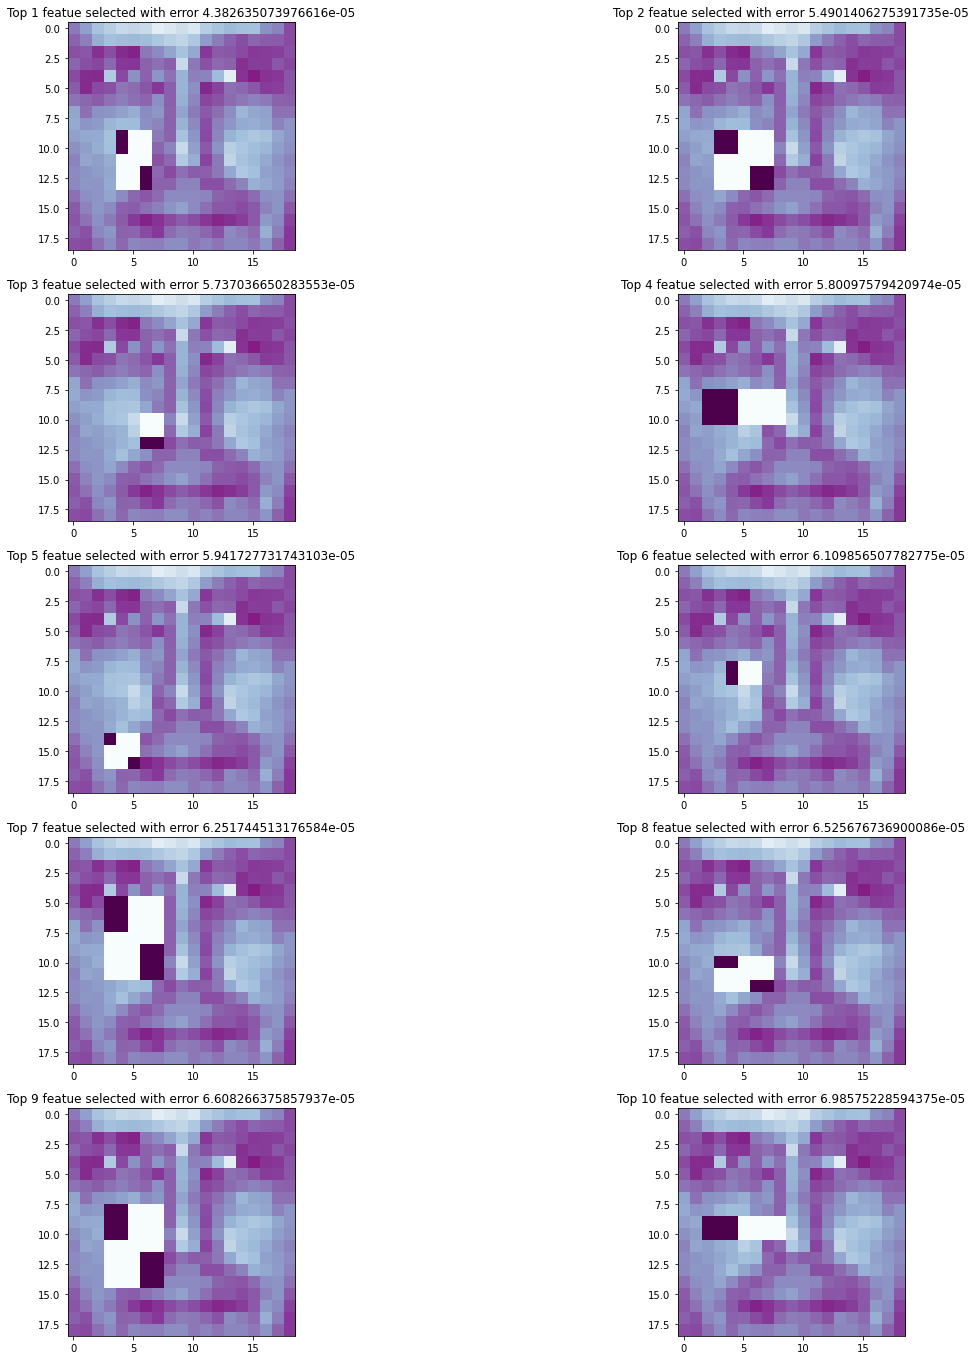

In [12]:
# Find top 10 features selected by AdaBoost
i=1

columns = 2
rows = 5
fig = plt.figure(figsize=(19, 19))
for (error, typ, features) in VJFD.top10_classifiers[9]:
    report_image = Image.open('../VJ_dataset/trainset/faces/face00002.png')
    img1 = ImageDraw.Draw(report_image)
    # pos = [i, j, w, h]
    for neg in features[1]:
        shape2=[(neg[0],neg[1]),(neg[0]+neg[2],neg[1]+neg[3])]
        img1.rectangle(shape2, fill ="blue")
    for pos in features[0]:
        shape1=[(pos[0],pos[1]),(pos[0]+pos[2],pos[1]+pos[3])]
        img1.rectangle(shape1, fill ="yellow")
    print(error)
    fig.add_subplot(rows,columns, i)
    fig.tight_layout()
    plt.imshow(report_image, cmap=plt.cm.BuPu_r)
    plt.title("Top {} featue selected with error {}".format(i,error))
    
    i+=1
# plt.savefig("top10/top10_round_{}.png".format(i,t),dpi=300)

In [13]:
# ROC curve trial 1
import sklearn.metrics as metrics
test_x = [tp[0] for tp in testing]
test_y = [tp[1] for tp in testing]
bool_predictions = [VJFD.classification(p)[1] for p in test_x]
fpr, tpr, threshold = metrics.roc_curve(test_y,bool_predictions)
roc_auc = metrics.auc(fpr, tpr)

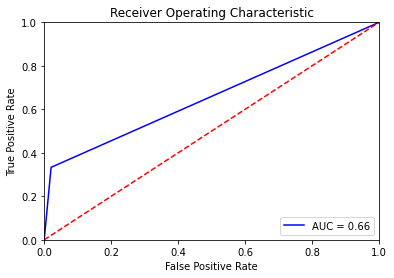

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig("ROC_round_{}.png".format(t),dpi=300)

In [13]:
# ROC curve trial 2
x,y = VJFD.roc_curve(testing)

plt.figure(figsize=(10,10))
plt.scatter(x, y,s=10 )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
# plt.xlim(0.0621,0.0622)
# plt.ylim(0.0621,0.0622)

Threshold = 0.0
Threshold = 0.01


KeyboardInterrupt: 

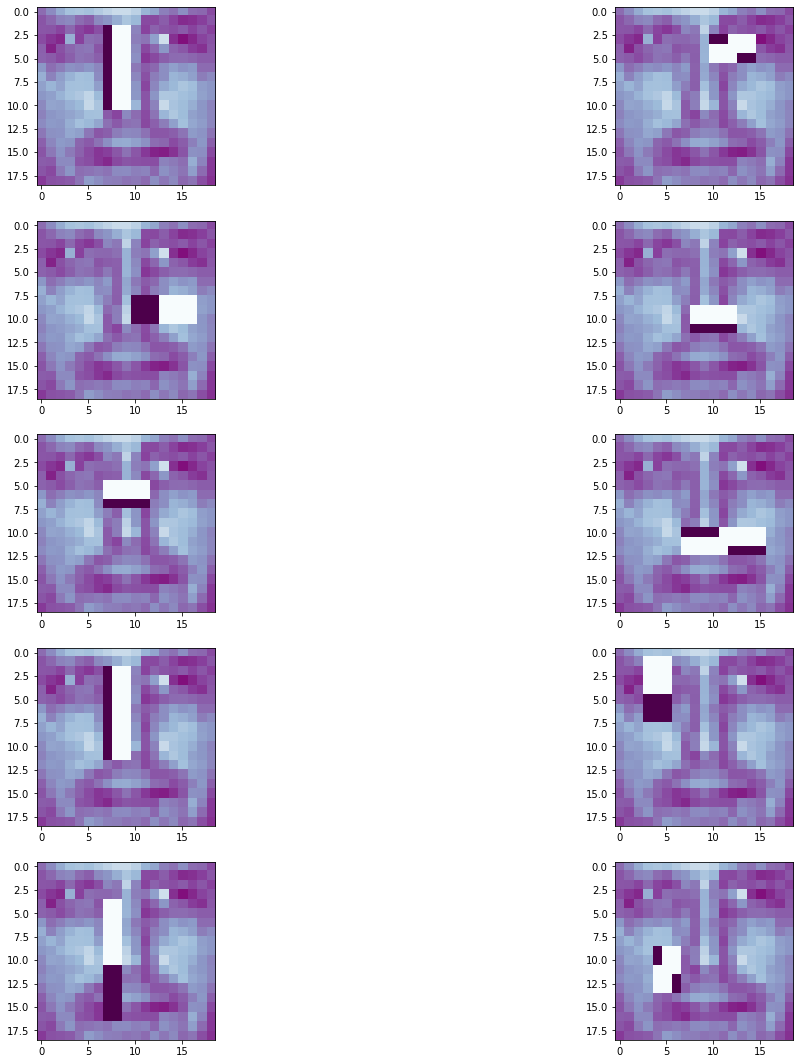

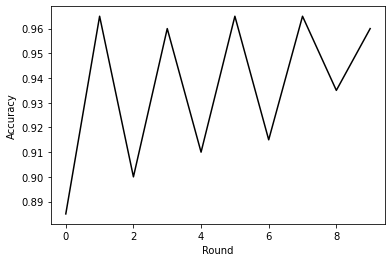

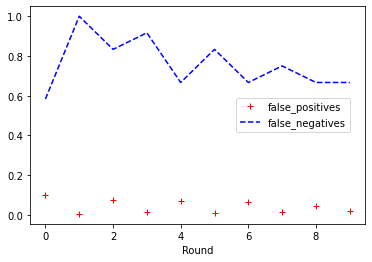

In [15]:
# Top features for each round      
columns = 2
rows = 5
fig = plt.figure(figsize=(19, 19))
for i in range(1,len(tmp_image)+1):
    fig.add_subplot(rows, columns, i)
    imshow(tmp_image[i-1], cmap=plt.cm.BuPu_r)
plt.show()

x=[]
for i in range(10):
    x.append(i)

plt.figure()
# plt.subplot(211)
plt.plot(x, VJFD.accuracy, 'k')
plt.ylabel('Accuracy')
plt.xlabel("Round")
plt.show()

# plt.subplot(212)
plt.plot(x, VJFD.fpr, 'r+', label='false_positives')
plt.xlabel("Round")

# plt.subplot(212)
plt.plot(x, VJFD.fnr, 'b--',label='false_negatives')
#plt.legend(loc="upper right")
plt.legend(loc='center left', bbox_to_anchor=(0.6, 0.5))
plt.xlabel("Round")

plt.show()

# Experimental code

In [ ]:
Haar_features = []
feature_coord=[]
n_featureTypes=6
flag=0
total_width = 19
total_height = 19
n_HarrType = {f:0 for f in range(1,n_featureTypes+1,1)}
for i in range(1, total_width+1):
    for j in range(1, total_height+1):
        w = 0
        while i+w < total_width and w < 10: # set feature size
            h = 0
            while j+h < total_height and h < 10:

                # i : left top x coord
                # j : left top y coord
                # i+w : right bottom x coord
                # j+h : right bottom y coord

                current = computeSum(ii_integral_image, i, j, w, h) # find current area sum

                # feature type 1
                # two vertical rectangle feature
#                 if j+2*h < total_height:
#                     vertical_1 = computeSum(ii_integral_image, i, j+h, w, h)
#                     Haar_features.append(current-vertical_1)
#                     if not flag:
#                         n_HarrType[1] += 1
# #                         feature_coord.append(("Two Vertical", [[i,j,w,h]],[[i,j+h,w,h]]))
#                 # feature type 2
#                 # two horizontal rectangle feature
#                 if i + 2*w < total_width:
#                     horizontal_1 = computeSum(ii_integral_image, i+w, j, w, h)
#                     Haar_features.append(horizontal_1-current) # compare the sum of two rectangles
#                     if not flag:
#                         n_HarrType[2] += 1
#                         feature_coord.append(("Two Horizontal", [[i+w,j,w,h]],[[i,j,w,h]]))

#                 # feature type 3
#                 # three horizontal rectangle feature      
#                 if i+3*w < total_width:    
#                     horizontal_2 = computeSum(ii_integral_image, i+2*w, j, w, h)
#                     Haar_features.append(horizontal_1-(horizontal_2+current))
#                     if not flag:
#                         n_HarrType[3]+=1
#                         feature_coord.append(("Three Horizontal",[[i+w, j, w, h]],[[i+2*w, j, w, h],[i,j,w,h]]))

#                 # feature type 4
#                 # three vertical rectangle feature    
#                 if j+3*h < total_height:    
#                     vertical_2 = computeSum(ii_integral_image, i, j+2*h, w, h)
#                     Haar_features.append(vertical_1-(vertical_2+current))
#                     if not flag:
#                         n_HarrType[4]+=1
#                         feature_coord.append(("Three Vertical",[[i, j+h, w, h]],[[i, j+2*h, w, h],[i,j,w,h]]))

                # feature type 5
                # Four diagonal rectangle feature
#                 if i+2*w < total_width and j+2*h < total_height:
#                     diagonal = computeSum(ii_integral_image,i+w,j+h,w,h)
#                     Haar_features.append((horizontal_1+vertical_1)-(current+diagonal))
#                     if not flag:
#                         n_HarrType[5] += 1
#                         feature_coord.append(("Four Rectangle", [[i+w,j,w,h],[i,j+h,w,h]],[[i,j,w,h],[i+w,j+h,w,h]]))
                
                # feature type 6
                # Four reverse diagonal rectangle feature
                if i+1 < total_width and j+1 < total_height:
                    if w-2>=0 and h-2>= 0:
                        center = computeSum(ii_integral_image,i+1,j+1,w-2,h-2)
                        Haar_features.append((current)-center)
                        if not flag:
                            n_HarrType[6] += 1
                            feature_coord.append(("Doughnut", [[i+1,j+1,w-2,h-2]],[[i,j,w,h]]))


                
                
                h += 1
            w += 1

In [ ]:
# from PIL import Image, ImageDraw
# import matplotlib.pyplot as plt
training[0]
ii_integral_image = integralImage(training[0][0])


In [ ]:
tmp_image = []
report_image = None
for (ty, r1, r2) in feature_coord:
    report_image = Image.open('../VJ_dataset/trainset/faces/face00002.png')
    img1 = ImageDraw.Draw(report_image)
    # pos = [i, j, w, h]
    for neg in r2:
        shape2=[(neg[0],neg[1]),(neg[0]+neg[2],neg[1]+neg[3])]
        img1.rectangle(shape2, fill ="blue")
    for pos in r1:
        shape1=[(pos[0],pos[1]),(pos[0]+pos[2],pos[1]+pos[3])]
        img1.rectangle(shape1, fill ="yellow")
    
    plt.imshow(report_image,cmap=plt.cm.BuPu_r)
    plt.show()